In [1]:
# My Datalab instance came with an older version and pre 1.0 releases
# are not necessarily backwards compatible.
# !pip install google-cloud-bigquery==0.30

In [2]:
from google.cloud import bigquery as bq

## Google Big Query Experiments

In [3]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/ntansaraviput/workspace/ml/p2rcc/navi/credentials/.google-cloud.json"

In [4]:
client = bq.Client()
dataset_ref = client.dataset('tcga_201607_beta', project='isb-cgc')

In [5]:
for t in client.list_tables(dataset_ref):
  table_ref = dataset_ref.table(t.table_id)
  table = client.get_table(table_ref)
  print (table.num_rows, table.num_bytes, t.table_id)

6322 1729204 Annotations
23797 6382147 Biospecimen_data
11160 4201379 Clinical_data
2646095 333774244 Copy_Number_segments
3944304319 445303830985 DNA_Methylation_betas
382335670 43164264006 DNA_Methylation_chr1
197519895 22301345198 DNA_Methylation_chr10
235823572 26623975945 DNA_Methylation_chr11
198050739 22359642619 DNA_Methylation_chr12
97301675 10986815862 DNA_Methylation_chr13
123239379 13913712352 DNA_Methylation_chr14
124566185 14064712239 DNA_Methylation_chr15
179772812 20296128173 DNA_Methylation_chr16
234003341 26417830751 DNA_Methylation_chr17
50216619 5669139362 DNA_Methylation_chr18
211386795 23862583107 DNA_Methylation_chr19
279668485 31577200462 DNA_Methylation_chr2
86858120 9805923353 DNA_Methylation_chr20
35410447 3997986812 DNA_Methylation_chr21
70676468 7978947938 DNA_Methylation_chr22
201119616 22705358910 DNA_Methylation_chr3
159148744 17968482285 DNA_Methylation_chr4
195864180 22113162401 DNA_Methylation_chr5
290275524 32772371379 DNA_Methylation_chr6
240010275 

In [ ]:
query = client.query("select * from `isb-cgc.tcga_201607_beta.Clinical_data` limit 5")
results = query.result()
for row in results:
  print(row)

# Gene Expression

In [6]:
%matplotlib inline

In [7]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
# sns.set_style("whitegrid")

## Data Preparation

In [9]:
import json
credentials_path = "credentials/.google-cloud.json"

with open(credentials_path) as f:
    credentials = json.load(f)
    project_id = credentials['project_id']

In [19]:
# df = pd.read_gbq("select * from `isb-cgc.tcga_201607_beta.Clinical_data` limit 5", project_id, dialect='standard')
q = "SELECT ParticipantBarcode, original_gene_symbol, normalized_count FROM `tcga_201607_beta.mRNA_KIRP`"
df = pd.read_gbq(q, project_id, dialect='standard')

In [64]:
df = df.dropna().drop_duplicates(subset=['ParticipantBarcode', 'original_gene_symbol'], keep=False)
genes = df.original_gene_symbol.unique()

## Visualization

In [10]:
GENE = 'TTN'

In [12]:
gdf = df.loc[df['original_gene_symbol'] == GENE]

[[]]

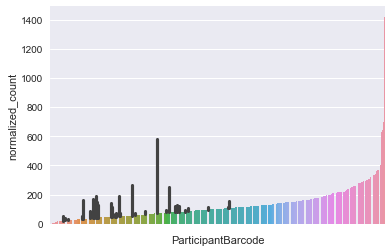

In [13]:
ax = sns.barplot(x="ParticipantBarcode", y="normalized_count", data=gdf)
ax.set(xticklabels=[])

In [ ]:
gene_pairs = [0]*int(len(genes)*(len(genes)-1)/2)
corr = [0]*int(len(genes)*(len(genes)-1)/2)

count = 0
for i in range(len(genes)-2):
    g1 = df.loc[df['original_gene_symbol'] == genes[i]].set_index('ParticipantBarcode')
    for j in range(i+1, len(genes)):
        g2 = df.loc[df['original_gene_symbol'] == genes[j]].set_index('ParticipantBarcode')
        g1g2 = g1.join(g2, rsuffix='2')
        gene_pairs[count] = (i,j)
        corr[count] = g1g2['normalized_count'].corr(g1g2['normalized_count2'])
        count += 1

In [48]:
g1 = df.loc[df['original_gene_symbol'] == 'TTN'][['ParticipantBarcode', 'normalized_count']].set_index('ParticipantBarcode')
g2 = df.loc[df['original_gene_symbol'] == 'EDN1'][['ParticipantBarcode', 'normalized_count']].set_index('ParticipantBarcode')

In [49]:
g1g2 = g1.join(g2, rsuffix='2')
g1g2['normalized_count'].corr(g1g2['normalized_count2'])

0.008742275511259626

In [ ]:
corr